# Test over Synthetic Data - part 2

Now, we'll try this method on another boolean function that has more predictors (both actual and false).

We will generate 1500 data points. Each data point will contain 100 predictors ($X_i = x_{i1}, x_{i2}, \dots, x_{i100}$) and the response of the system ($y_i$). To generate the random data points $\mathbf{X}=<X_1, X_2, \dots, X_{1500}>$, we sample a thousand times from the binomial distribution with $n=100$ and $p=0.5$.

In [1]:
import importlib
import sys
main_spec = importlib.util.find_spec("main")
found = main_spec is not None
project_root = ""
if not found:
    !rm -rf noisy-generalized-boolean
    !git clone https://github.com/RohanBh/noisy-generalized-boolean
    sys.path.append('noisy-generalized-boolean')
    project_root = "noisy-generalized-boolean/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import main
from IPython.display import FileLink
import os

#### NOTE
Set the variable `load_samples` to `False` if you want to run a new MCMC (which may take a few minutes). Otherwise, the data (samples) is loaded from the previous MCMC that was run.

In [3]:
load_samples = True

In [4]:
X = np.random.rand(1500, 100)
X = np.round(X)
X

array([[0., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.]])

Now that we have $\mathbf{X}$, it's time to generate our synthetic system's response $\mathbf{Y}$. We say that the underlying boolean function depends only on the following 6 predictors out of 100 predictors:
                $$M = <x_{13}, x_{31}, x_{38}, x_{55}, x_{77}, x_{89}>$$

We'll represent this function by $F: \{0,1\}^6 \rightarrow \mathbb{Z}_{4} $, where $\mathbb{Z}_{4} = \{0, 1, 2, 3\}$.

The choice of $F$ is very simple. If the *boolean OR* of the actual predictors is *True*, then the bool_func generates:

$$
\begin{align*}
     y &= 0 \:\text{ w.p. }\: 0.9 \\
       &= 1 \:\text{ w.p. }\: 0.05 \\
       &= 2 \:\text{ w.p. }\: 0 \\
       &= 3 \:\text{ w.p. }\: 0.05
\end{align*}
$$

And if the *boolean OR* evaluates to be *False*, then bool_func generates

$$
\begin{align*}
     y &= 0 \:\text{ w.p. }\: 0 \\
       &= 1 \:\text{ w.p. }\: 0.1 \\
       &= 2 \:\text{ w.p. }\: 0.7 \\
       &= 3 \:\text{ w.p. }\: 0.2
\end{align*}
$$

Here "w.p." abbreviation stands for *with probability*.

In [5]:
def bool_func(xi):
    """Takes an row of truth table and returns the response 
    according to the boolean function"""
    on_true = [0.9, 0.05, 0, 0.05]
    on_false = [0, 0.1, 0.7, 0.2]
    weights =  on_true if np.any(xi) else on_false
    return np.random.choice(4, p=weights)

With the above defined function, we'll generate the response of the system for input $\mathbf{X}$.

In [6]:
X_actual = X[:, [89, 77, 55, 38, 31, 13]]
X_actual.shape

(1500, 6)

Now, we generate the response of the synthetic system $\mathbf{Y}$, for all $1500$ rows in $\mathbf{X}$.

In [7]:
Y = np.apply_along_axis(bool_func, axis=1, arr=X_actual)
Y.shape

(1500,)

Now we have all we need. Let's see if our statistical method can predict which predictors does the response depends upon.

We call the `metropolis` function from the module `main`. This function uses a **Metropolis-Hastings** MCMC algorithm. This algorithm runs a markov chain over the model space $\mathcal{M}$ and generates samples of possible models with the posterior probability $P(M \mid \mathbf{Y}, \mathbf{X})$. This behavior is true only after the markov chain has reached a steady state.

The `metropolis` function returns the generated samples.

In [8]:
samples = []
if not load_samples:
    samples = main.metropolis(X, Y, q=4, iterations=50000, interval=5000, show_progress=True)
    pd.DataFrame(samples).to_csv(f"{project_root}data/mcmc-2.csv")
else:
    samples = pd.read_csv(f"{project_root}data/mcmc-2.csv", index_col=0).values.tolist()

In [9]:
FileLink(f"{project_root}data/mcmc-2.csv")

/home/rohan/Projects/PythonProjects/generalized-noisy-boolean/data/mcmc-2.csv

Click on the link above to download the generated samples.

In [10]:
plt.ioff() # turn off interactive mode for matplotlib

In [11]:
data = np.array(samples)
data.shape

(49581, 100)

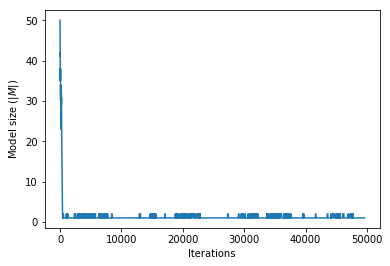

In [12]:
plt.plot(np.arange(data.shape[0]), np.count_nonzero(data, axis=1))
plt.xlabel("Iterations")
plt.ylabel(r"Model size ($\vert M \vert$)")
plt.show()

We see that the markov chain enters steady state after around 10000 iterations. We discard the samples before that.

In [13]:
data = data[10000:]
data.shape

(39581, 100)

The next plot gives the posterior probability that predictor $j$ is a part of the model given $Y$ and $X$.

$$
     \begin{align*}
     P(j \in M \mid \mathbf{Y}, \mathbf{X}) &= \sum_{M \in \mathcal{M}} P(j \in M \mid \mathbf{Y}, \mathbf{X}, M) P(M \mid \mathbf{Y}, \mathbf{X}) \\
         &= \hat{\mathbb{E}}[I_M(j)]_{P(M|\mathbf{Y},\mathbf{X})} \\
         &= \frac{1}{T} \sum_{t=1}^T I_{M^{(t)}} (j)
     \end{align*}
$$

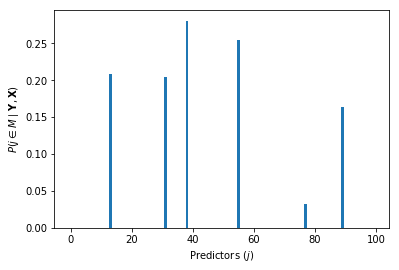

In [14]:
plt.bar(np.arange(data.shape[1]), data.mean(axis=0))
plt.xlabel("Predictors ($j$)")
plt.ylabel(r"$P(j \in M \mid \mathbf{Y}, \mathbf{X})$")
plt.show()

We can see that the **actual predictors** have very high posterior probability.

In [15]:
actual_model = data.mean(axis=0) > 0
actual_model.nonzero()

(array([13, 31, 38, 55, 77, 89]),)

As we can see, the only predictors with non zero posterior are the ones belonging to our original boolean function.

In [16]:
models = pd.DataFrame(data).assign(count=-1).groupby(list(range(100))).count()

Let's plot the models

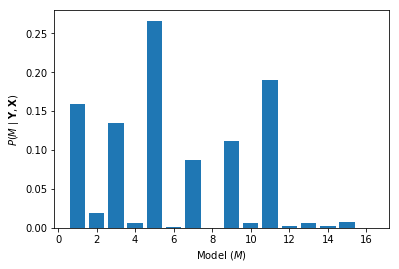

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
model_counts = models.loc[:, 'count'].values
ax.bar(np.arange(1, model_counts.size + 1), model_counts / model_counts.sum())
ax.set_xlabel("Model ($M$)")
ax.set_ylabel(r"$P(M \mid \mathbf{Y}, \mathbf{X})$")
plt.show()

Looks like the 5th model has a very high posterior. Let's see which predictors it contains.

In [18]:
model_estimate = models.reset_index().iloc[4,:100].values > 0
model_estimate.nonzero()

(array([38]),)

This is disappointing. Let's compare the log posterior of actual and estimated models.

In [19]:
print(main.posterior(Y, X, model_estimate, 0.1, 4, np.e, 4))
print(main.posterior(Y, X, actual_model, 0.1, 4, np.e, 4))

-647.3964116216055
-734.0178634863765


The actual model does have a lower posterior.